In [1]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Bernoulli

import torchvision
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

import cv2
# from time import time

# from torch.utils.tensorboard import SummaryWriter

# if gpu is to be used
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(device)

cpu


# Paratemer setup

In [164]:
BATCH_SIZE = 64
INPUT_DIM = 28*28
LATENT_DIM = 25

N_EPOCHS = 20
LEARNING_RATE = 1e-3
# BETA = 1
CHANNELS = 1

# Dataloader + downloading dataset

In [65]:
landmarks_frame = pd.read_csv('../runs/dqn/gridworld/static_water/2019-09-12-15:17:16/state-action-catastrophe.csv',
                              index_col=0)

img_name = landmarks_frame.iloc[0, 0]

print('Image name: {}'.format(img_name))

Image name: 0-0.png


(150, 150, 3)


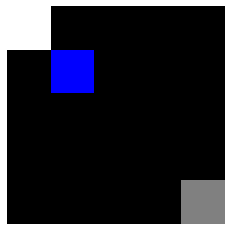

In [66]:
data_folder = '../runs/dqn/gridworld/static_water/2019-09-12-15:17:16/states/'
# image = cv2.imread(os.path.join(data_folder, img_name), 0)  # Use for grayscale image
image = cv2.imread(os.path.join(data_folder, img_name))
print(image.shape)
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [104]:
from torch.utils.data import Dataset, DataLoader

class GridworldDataset(Dataset):
    """Gridworld dataset."""

    def __init__(self, csv_file, images_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            images_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.gridworlds_df = pd.read_csv(csv_file, index_col=0)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.gridworlds_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_file = os.path.join(self.images_dir,
                                self.gridworlds_df.iloc[idx, 0])
        image = cv2.imread(img_file, 0)  # 0 is used to load grayscale image
#         image = cv2.imread(img_file)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         landmarks = self.landmarks_frame.iloc[idx, 1:]
#         landmarks = np.array([landmarks])
#         landmarks = landmarks.astype('float').reshape(-1, 2)
#         sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            image = self.transform(image)
            
        sample = {'image': image}
        label = torch.empty(1)
        return image, label

In [105]:
def tensor_scale_up(tensor, scale=10):
    return torch.from_numpy(np.kron(tensor.detach(), np.ones((scale, scale)))).float()

In [106]:
csv_file = '../runs/dqn/gridworld/static_water/2019-10-12-22:25:11/state-action-catastrophe.csv'
images_dir = '../runs/dqn/gridworld/static_water/2019-10-12-22:25:11/states/'

gridworld_dataset = GridworldDataset(csv_file=csv_file, images_dir=images_dir, transform=transforms.ToTensor())

In [107]:
train_loader = DataLoader(gridworld_dataset, batch_size=64,
                          shuffle=True)
test_loader = DataLoader(gridworld_dataset, batch_size=64,
                         shuffle=True)

torch.Size([64, 1, 5, 5]) torch.Size([64, 1, 50, 50])


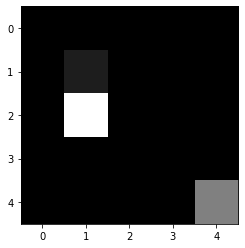

In [71]:
sample, _ = next(iter(train_loader))
print(sample.shape, tensor_scale_up(sample).shape)
plt.imshow(sample[0].view(5,5).numpy(), cmap='gray')

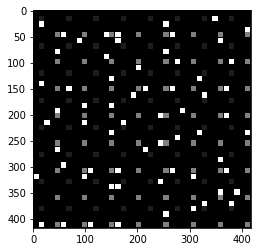

In [72]:
img = torchvision.utils.make_grid(tensor_scale_up(sample), nrow=8).numpy()
plt.imshow(np.transpose(img, (1, 2, 0)), cmap='gray_r')

## Inspecting the first iteration of images and labels (not part of the final code)

In [73]:
# get batch of images and labels to find out its shape
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 5, 5])
torch.Size([64, 1])


In [74]:
# Minimum and maximum value in the first image (pixel range)
min(images[0].view(-1)), max(images[0].view(-1))

(tensor(0.), tensor(1.))

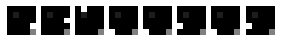

In [75]:
# display 60 images from current iteration
figure = plt.figure()
num_of_images = 8
for index in range(num_of_images):
    plt.subplot(6, 10, index+1)
    plt.axis('off')
    np_imgs = images[index].view(1,5,5).numpy()
    plt.imshow(np.transpose(np_imgs, (1,2,0)).squeeze(), cmap='gray')

In [76]:
images.shape

torch.Size([64, 1, 5, 5])

In [39]:
pom = torch.distributions.Bernoulli(images)
pom_sample = pom.sample()
# pom_sample
pom_np_sample = np.transpose(pom_sample[1].view(3,150,150).numpy(), (1,2,0))
plt.imshow(pom_np_sample)
# plt.imshow(images[1].view(28,28).numpy(), cmap='gist_gray')

RuntimeError: shape '[3, 150, 150]' is invalid for input of size 25

# VAE implementation

In [193]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
#         self.fc1 = nn.Linear(INPUT_DIM, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.conv1 = nn.Conv2d(1, 16, 5)
#         self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(CHANNELS*5*5, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, LATENT_DIM)
        self.fc_logvar = nn.Linear(256, LATENT_DIM)
    
    def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x_mu = self.fc_mu(x)
        x_log_var = self.fc_logvar(x)
        
        return x_mu, x_log_var
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(LATENT_DIM, 256)
        self.fc2 = nn.Linear(256, CHANNELS*5*5)
#         self.pool1 = nn.MaxUnpool2d(60, 60)
#         self.upsample = nn.Upsample(scale_factor=60)
#         self.conv1 = nn.ConvTranspose2d(32, 16, 3)
#         self.conv2 = nn.ConvTranspose2d(16, 1, 3)
#         self.fc2 = nn.Linear(128, 256)
#         self.fc3 = nn.Linear(256, INPUT_DIM)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(x.shape[0], CHANNELS, 5, 5)
#         x = self.pool1(x)
#         x = F.relu(self.conv1(x))
#         x = self.conv2(x)
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         x = torch.sigmoid(x)
        
        return x
    
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def reparameterize(self, x_mu, x_std):
        q_zx = Normal(x_mu, x_std)
        p_z = Normal(torch.zeros_like(x_mu), torch.ones_like(x_std))
        return q_zx, p_z
        
    def forward(self, x):
        out = dict()
        
        x_mu, x_logvar = self.encoder(x)
        x_std = torch.exp(x_logvar / 2)  # sigma = e^(log_var / 2)

        # q(z|x) = Normal(z | x_mu, x_logvar)
        q_zx = Normal(x_mu, x_std)
        p_z = Normal(torch.zeros_like(x_mu), torch.ones_like(x_std))
#         q_zx, p_z = self.reparameterize(x_mu, x_std)

        # sample from q(z|x) with reparametrization
        z = q_zx.rsample()

        # p(x|z) = Bernoulli()
        z_mu = decoder(z)
        z_mu = z_mu.view(z_mu.shape[0], -1)
        p_xz = Bernoulli(z_mu)
        
        out['q_zx'] = q_zx
        out['p_z'] = p_z
        out['z'] = z
        out['z_mu'] = z_mu
        out['p_xz'] = p_xz
        return out
    
encoder = Encoder().to(device)
decoder = Decoder().to(device)
vae = VAE(encoder, decoder).to(device)

print(encoder)
print(decoder)
print(vae)
n_params_encoder = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
n_params_decoder = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
n_params_vae = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters in encoder: %d' % n_params_encoder)
print('Number of parameters in decoder: %d' % n_params_decoder)
print('Number of parameters in vae: %d' % n_params_vae)

Encoder(
  (fc1): Linear(in_features=25, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=25, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=25, bias=True)
)
Decoder(
  (fc1): Linear(in_features=25, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=25, bias=True)
)
VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=25, out_features=256, bias=True)
    (fc_mu): Linear(in_features=256, out_features=25, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=25, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=25, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=25, bias=True)
  )
)
Number of parameters in encoder: 19506
Number of parameters in decoder: 13081
Number of parameters in vae: 32587


Calculate loss (ELBO):
\begin{equation*}
\log p(x) \ge \mathbb{E}_{q(z \mid x)} \left[ \log \frac{p(x \mid z) p(z)}{q(z \mid x)} \right]
\end{equation*}

In [194]:
import torch.optim as optim

def ELBO_loss(x, z, q_zx, p_xz, p_z, **kwargs):
    x = x.view(x.shape[0], -1)
    log_prob_p_xz = p_xz.log_prob(x).sum(dim=1)
    log_prob_p_z = p_z.log_prob(z).sum(dim=1)
    log_prob_q_zx = q_zx.log_prob(z).sum(dim=1)
    loss = -torch.mean(log_prob_p_xz + torch.tensor([1.0]).to(device)*(log_prob_p_z - log_prob_q_zx))
#     print(loss, torch.mean(log_prob_p_xz).item(), torch.mean(log_prob_p_z).item(), torch.mean(log_prob_q_zx).item())
    return loss#, torch.mean(log_prob_p_xz), torch.mean(log_prob_p_z - log_prob_q_zx)

# loss_function = nn.MSELoss()
loss_function = ELBO_loss
optimizer = optim.Adam(vae.parameters(), lr=0.0001)

### Test the forward pass

In [195]:
dataiter = iter(train_loader)

In [196]:
images, labels = next(dataiter)
images.shape

torch.Size([64, 1, 5, 5])

In [197]:
# test the forward pass
# images, labels = next(iter(train_loader))
images, labels = next(dataiter)
x = images.to(device)
x = torch.autograd.Variable(x)
out = vae(x)

loss = loss_function(x=x, **out)
loss
# fc_weights_prev = vae.decoder.fc3.weight.data.numpy()
# print(fc_weights_prev.sum())

tensor(16.2294, grad_fn=<NegBackward>)

In [113]:
x[0], out['z_mu'][0].view(1,5,5)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.1137, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.5020]]]),
 tensor([[[0.5671, 0.4408, 0.5134, 0.3209, 0.0000],
          [0.3553, 0.0920, 0.0000, 0.0000, 0.0000],
          [0.0111, 0.2856, 0.0104, 0.5476, 0.1620],
          [0.4850, 0.1475, 0.3157, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.3689, 0.0000]]], grad_fn=<ViewBackward>))

In [114]:
out['z_mu'].shape, x.shape

(torch.Size([64, 25]), torch.Size([64, 1, 5, 5]))

In [ ]:
# zero the parameter gradients
optimizer.zero_grad()
loss.backward()
print(vae.decoder.fc3.weight.grad)
print(vae.encoder.fc_mu.weight.grad)
print(vae.encoder.fc_logvar.weight.grad)
optimizer.step()

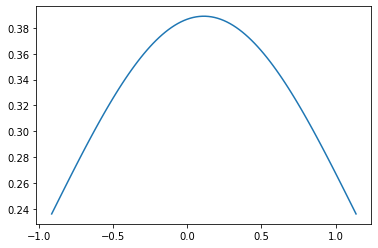

In [78]:
import scipy.stats as stats
pom_mu, pom_sigma = x_mu[0][0].item(), x_std[0][0].item()
pom_x = np.linspace(pom_mu - pom_sigma, pom_mu + pom_sigma, 100)
pom_y = stats.norm.pdf(pom_x, pom_mu, pom_sigma)
plt.plot(x, pom_y)
plt.show()

## Train the network

In [199]:
# train the network
train_loss, train_kl = [], []
valid_loss, valid_kl = [], []

print("Using device:", device)

for epoch in range(N_EPOCHS):
    batch_loss = []
    vae.train()
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        x, labels = data[0].to(device), data[1].to(device)
        
        # forward + backward + optimize
        out = vae(x)
        loss = loss_function(x=x, **out)
#         print('loss: ', loss)
#         print(vae.decoder.fc1.weight.data.numpy().sum())
        # zero the parameter gradients
        optimizer.zero_grad()
        loss.backward()
#         print(vae.decoder.fc1.weight.grad.sum())
        optimizer.step()
        
        batch_loss.append(loss.item())
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
#             print(loss.item(), log_prob_p_xz.item(), log_prob_p_z.item(), log_prob_q_zx.item())
            running_loss = 0.0
    
    train_loss.append(np.mean(batch_loss))
    
    with torch.no_grad():
        vae.eval()
        batch_loss = []
        
#         for data in test_loader:
        data = next(iter(test_loader))
        x, labels = data[0].to(device), data[1].to(device)

        out = vae(x)
        
        loss = loss_function(x=x, **out)
        
        batch_loss.append(loss.item())
        valid_loss.append(np.mean(batch_loss))
        
        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = out['z_mu'].detach().to("cpu")
        z = out['z'].detach().to("cpu").numpy()


Using device: cpu
[1,   100] loss: 8.096
[2,   100] loss: 8.011
[3,   100] loss: 7.983
[4,   100] loss: 7.883
[5,   100] loss: 7.868
[6,   100] loss: 7.927
[7,   100] loss: 7.981
[8,   100] loss: 7.873
[9,   100] loss: 7.901
[10,   100] loss: 7.812
[11,   100] loss: 7.875
[12,   100] loss: 7.847
[13,   100] loss: 7.886
[14,   100] loss: 7.744
[15,   100] loss: 7.781
[16,   100] loss: 7.713
[17,   100] loss: 7.684
[18,   100] loss: 7.602
[19,   100] loss: 7.737
[20,   100] loss: 7.600
[21,   100] loss: 7.581
[22,   100] loss: 7.582
[23,   100] loss: 7.617
[24,   100] loss: 7.572
[25,   100] loss: 7.548
[26,   100] loss: 7.603
[27,   100] loss: 7.550
[28,   100] loss: 7.517
[29,   100] loss: 7.460
[30,   100] loss: 7.530
[31,   100] loss: 7.496
[32,   100] loss: 7.385
[33,   100] loss: 7.382
[34,   100] loss: 7.441
[35,   100] loss: 7.466
[36,   100] loss: 7.370
[37,   100] loss: 7.405
[38,   100] loss: 7.435
[39,   100] loss: 7.336
[40,   100] loss: 7.343
[41,   100] loss: 7.352
[42,   

### Train & validation loss and KL

[Text(0, 0.5, 'loss'),
 Text(0.5, 0, 'epoch'),
 Text(0.5, 1.0, 'Training & validation loss (from 2nd epoch)')]

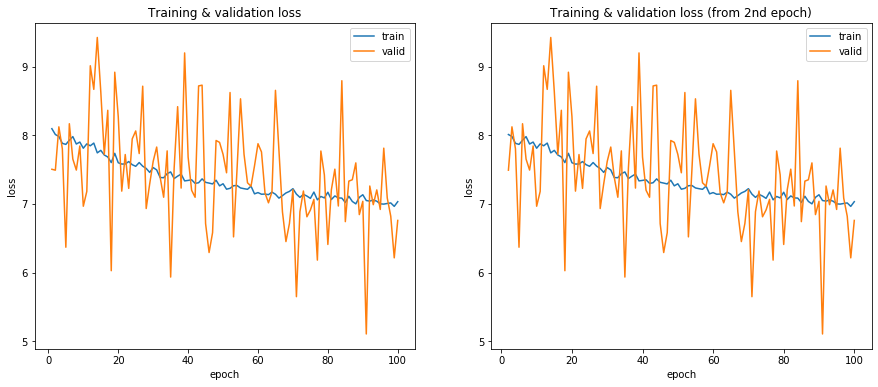

In [200]:
# Results for convolution layers
vae.eval()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
x = range(1, epoch + 2)
sns.lineplot(x=x, y=train_loss, ax=ax[0], label="train")
sns.lineplot(x=x, y=valid_loss, ax=ax[0], label="valid")
ax[0].set(xlabel="epoch",
          ylabel="loss",
          title="Training & validation loss")

sns.lineplot(x=x[1:], y=train_loss[1:], ax=ax[1], label="train")
sns.lineplot(x=x[1:], y=valid_loss[1:], ax=ax[1], label="valid")
ax[1].set(xlabel="epoch",
          ylabel="loss",
          title="Training & validation loss (from 2nd epoch)")

### Latent space visualization

In [172]:
images.shape

torch.Size([64, 1, 5, 5])

In [173]:
from sklearn.decomposition import PCA

agg_mu = torch.tensor([])
agg_mu_1 = []
agg_mu_2 = []
agg_l = []

with torch.no_grad():
    it = iter(test_loader)
    for i in range(50):
        images, labels = next(it)
        x = images.view(images.shape[0], -1)
        latent_mu, _ = vae.encoder(x)
        agg_mu = torch.cat((agg_mu, latent_mu), dim=0)
        if latent_mu.shape[1] > 2:
            latent_mu = PCA(n_components=2).fit_transform(latent_mu.numpy())
        agg_mu_1 += list(latent_mu[:,0])
        agg_mu_2 += list(latent_mu[:,1])
        agg_l += list(labels.numpy())

# pom_images, pom_labels = next(iter(test_loader))
# pom_images.shape, pom_labels.shape
len(agg_mu_1), len(agg_mu_2), len(agg_l), agg_mu.shape

(3200, 3200, 3200, torch.Size([3200, 25]))

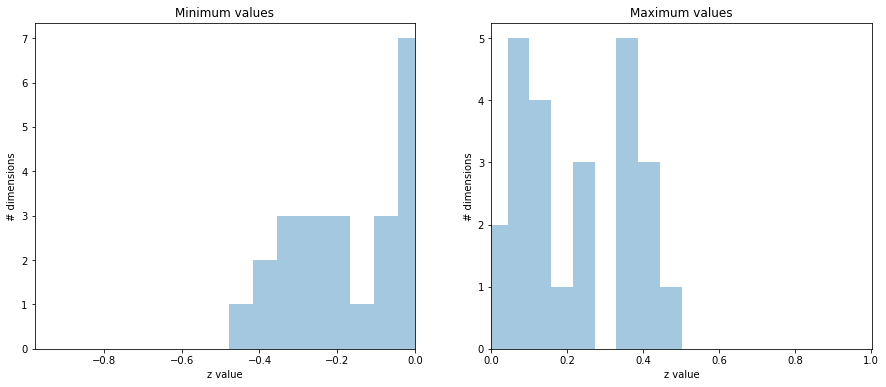

In [174]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

mins = torch.min(agg_mu, dim=0).values.numpy()
sns.distplot(mins, bins=10, kde=False, ax=ax[0])
ax[0].set_xlim((mins.min() - 0.5, 0))
ax[0].set(xlabel="z value",
          ylabel="# dimensions",
          title="Minimum values")

maxs = torch.max(agg_mu, dim=0).values.numpy()
sns.distplot(maxs, bins=10, kde=False, ax=ax[1])
ax[1].set_xlim((0, maxs.max() + 0.5))
ax[1].set(xlabel="z value",
          ylabel="# dimensions",
          title="Maximum values")

plt.show()

No handles with labels found to put in legend.


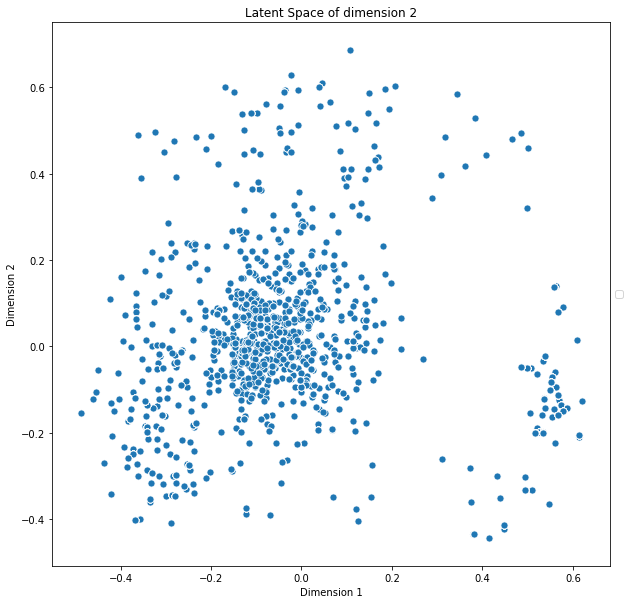

In [175]:
colors = ['#7f3b08','#b35806','#e08214','#fdb863','#fee0b6','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b']
pal = sns.color_palette(colors)

f, ax = plt.subplots(1, figsize=(10,10))
sns.scatterplot(ax=ax, x=agg_mu_1, y=agg_mu_2, palette=pal, s=50)#, hue=agg_l)
ax.set_title('Latent Space of dimension 2')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

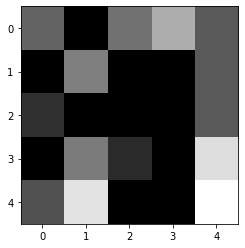

In [176]:
with torch.no_grad():
#     z = torch.tensor([[0.05, 0.05]])
    z = torch.zeros((1, 25))
    if CHANNELS == 3:
        np_img = vae.decoder(z).view(3,5,5)
        plt.imshow(np.transpose(np_img, (1,2,0)), cmap='gist_gray')
    elif CHANNELS == 1:
        plt.imshow(vae.decoder(z).squeeze(), cmap='gist_gray')

torch.Size([225, 2])


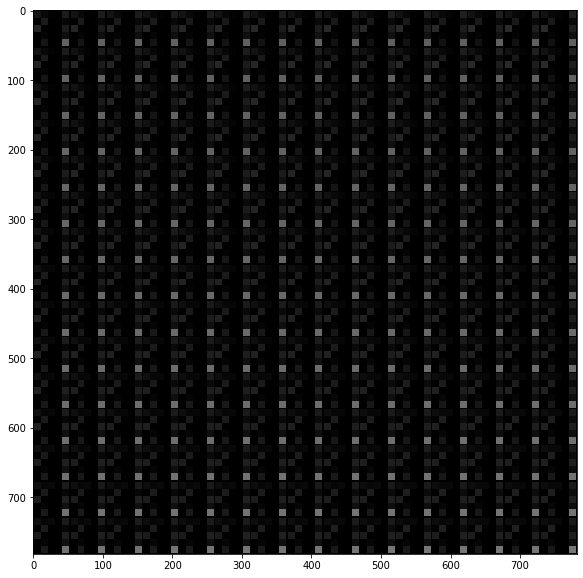

In [154]:
# sample images representing the whole latent space
n_samples_sqrt = 15

f, ax = plt.subplots(1, figsize=(10,10))
with torch.no_grad():
    xs = np.linspace(mins[0], maxs[0], num=n_samples_sqrt)
    ys = np.linspace(mins[1], maxs[1], num=n_samples_sqrt)
    
#     sample = torch.tensor([(x, y,0,0,0,0,0,0,0,0) for x in xs for y in ys]).float()
    sample = torch.tensor([(x, y) for x in xs for y in ys]).float()
    print(sample.shape)
    sample = vae.decoder(sample).view(n_samples_sqrt**2,1,5,5)
    img = torchvision.utils.make_grid(tensor_scale_up(sample), nrow=n_samples_sqrt).numpy()
    ax.imshow(np.transpose(img, (1, 2, 0)), cmap='gray_r')

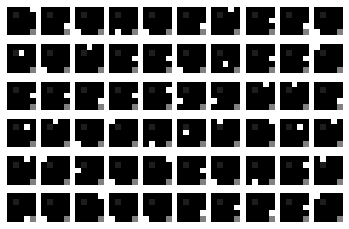

In [204]:
figure = plt.figure()
num_of_images = 60
for index in range(num_of_images):
    plt.subplot(6, 10, index+1)
    plt.axis('off')
    if CHANNELS == 3:
        plt.imshow(np.transpose(images[index].numpy(), (1,2,0)).squeeze(), cmap='gray_r')
    elif CHANNELS == 1:
        plt.imshow(images[index].numpy().squeeze(), cmap='gray')

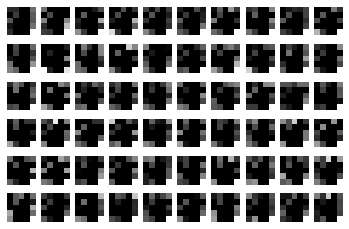

In [205]:
with torch.no_grad():
#     x_hat, mu, log_var, z = vae(images)
    out = vae(images)
    figure = plt.figure()
    num_of_images = 60
    for index in range(num_of_images):
        plt.subplot(6, 10, index+1)
        plt.axis('off')
        if CHANNELS == 3:
            plt.imshow(np.transpose(out['z_mu'][index].view(3,5,5).numpy(), (1,2,0)).squeeze(), cmap='gray_r')
        elif CHANNELS == 1:
            plt.imshow(out['z_mu'][index].view(5,5).numpy(), cmap='gray')

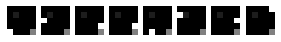

In [123]:
figure = plt.figure()
num_of_images = 8
for index in range(num_of_images):
    plt.subplot(6, 10, index+1)
    plt.axis('off')
    if CHANNELS == 3:
        plt.imshow(np.transpose(images[index].numpy(), (1,2,0)).squeeze(), cmap='gray_r')
    elif CHANNELS == 1:
        plt.imshow(images[index].numpy().squeeze(), cmap='gray')

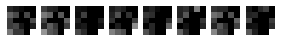

In [124]:
with torch.no_grad():
#     x_hat, mu, log_var, z = vae(images)
    out = vae(images)
    figure = plt.figure()
    num_of_images = 8
    for index in range(num_of_images):
        plt.subplot(6, 10, index+1)
        plt.axis('off')
        if CHANNELS == 3:
            plt.imshow(np.transpose(out['z_mu'][index].view(3,5,5).numpy(), (1,2,0)).squeeze(), cmap='gray_r')
        elif CHANNELS == 1:
            plt.imshow(out['z_mu'][index].view(5,5).numpy(), cmap='gray')

In [113]:
out['z_mu'].shape

torch.Size([8, 25])